# Week8 - Decision Tree, KNN, NB, SVM Homework

* Do a quick EDA to understand your data and explain what you need for your pipeline.
* Explain what metric would be appropriate for this task (1 sentence).
* Explain your game plan
* Create a preprocessing pipeline (without the model).

* Train-test split
* Create pipelines for the following models and use preprocessing pipeline you created in the previous step
    - Decision Trees
    - Random Forests
    - KNN
    - NB
    - SVM
  
* Define params for GridSearchCV for all models
* Evaluate the models

* Explain findings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [11]:
# DON'T CHANGE ANYTHING HERE....
random.seed(42)
def remove_values(df, cols, perc=0.001):
    for i in cols:
        mask = pd.Series(random.choices([0,1], weights=[perc, 1-perc], k=len(df[i])))
        df[i] = [ x if i==1 else None for x, i in zip(df[i], mask)]

def create_df(size=1000000):
    from sklearn.datasets import make_classification

    X, y = make_classification(
        n_samples=size,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_classes=2,
        flip_y=0.2,
        random_state=4
    )
    
    df = pd.DataFrame(X)
    df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    df.f1 = df.f1**2
    df.f2 = df.f2**2
    df.f3 = df.f3*1000
    
    flag = random.choices([True, False], weights=[0.65, 0.35], k=len(y))
    f6 = ['A' if i == 0 else 'B' for i in y]
    
    f6 = [f if i else ('B' if f=='A' else 'A') for i,f in zip(flag, f6)]
    df['f6'] = f6
    
    remove_values(df, df.columns, perc=0.05)
    
    return df, pd.Series(y)
    
X, y = create_df()

In [12]:
# eda code
X.head()

,f1,f2,f3,f4,f5,f6
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,B
1,NaN,1.764094,-873.709051,2.084035,0.387268,A
2,8.663599,NaN,-563.461158,-0.044922,2.512673,A
3,NaN,3.899908,753.129656,1.565944,-3.771516,A
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,A


<AxesSubplot: >

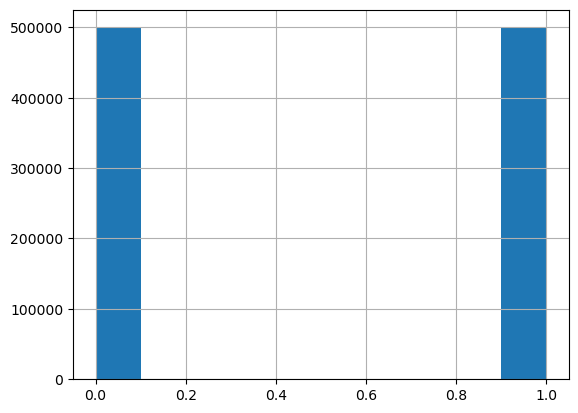

In [13]:
y.hist()

In [14]:
X.isna().sum()

f1    50067
f2    50116
f3    50196
f4    49556
f5    49851
f6    50017
dtype: int64

In [15]:
X.isna().sum() / X.shape[0] * 100

f1    5.0067
f2    5.0116
f3    5.0196
f4    4.9556
f5    4.9851
f6    5.0017
dtype: float64

It looks like the number of samples for each class is fairly balanced. This is good as we won;t have to deal with class imbalance. Furthremore, the number of null values per column is also very similar. If we divide the number of samples by total row count, we get percentage of rows that are null per column. Given that we only have ~5% of the rows in each column are null, I decided to drop these rows.

In [16]:
X["target"] = y

In [ ]:
# removing null values
X.dropna(inplace=True)
X.isna().sum()

f1        0
f2        0
f3        0
f4        0
f5        0
f6        0
target    0
dtype: int64

In [18]:
y = X["target"]
X.drop(columns=["target"], inplace=True)
X.head()

,f1,f2,f3,f4,f5,f6
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,B
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,A
5,1.707131,3.219006,-1563.767809,1.192324,-1.980512,B
7,2.776157,2.004715,1226.955079,0.304439,4.092840,B
8,2.141662,3.717246,-485.810816,-0.527697,0.199336,A


Great. The number of rows with null values is 0 now. Lets create a pipeline

In [19]:
X.shape, y.shape

((735280, 6), (735280,))

In [20]:
X.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6'], dtype='object')

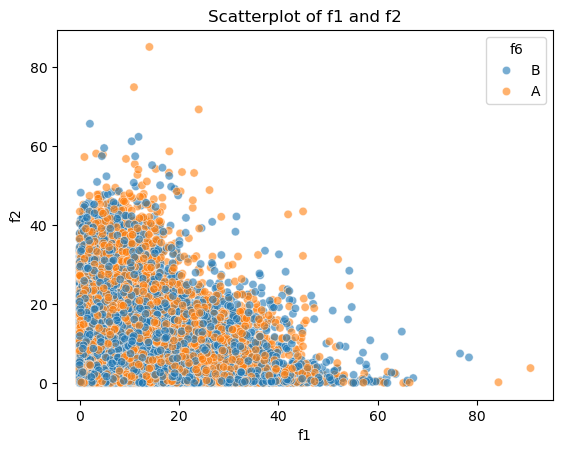

In [18]:
sns.scatterplot(x = "f1", y = "f2", hue="f6", data=X, alpha=0.6)
plt.title("Scatterplot of f1 and f2")
plt.show()

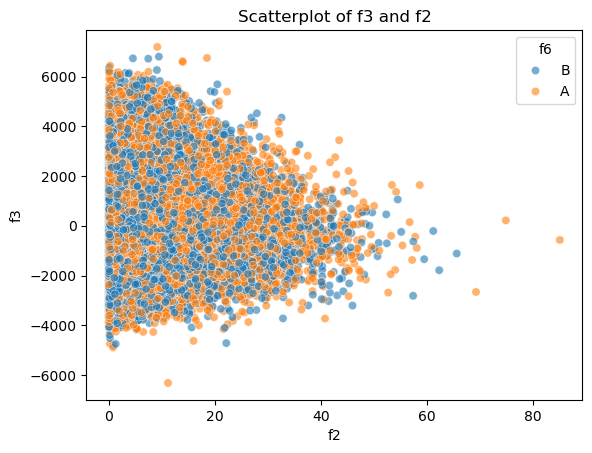

In [19]:
sns.scatterplot(x = "f2", y = "f3", hue="f6", data=X, alpha=0.6)
plt.title("Scatterplot of f3 and f2")
plt.show()

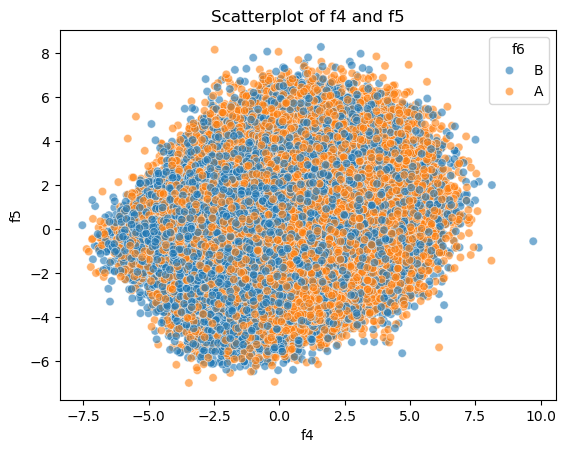

In [20]:
sns.scatterplot(x = "f4", y = "f5", hue="f6", data=X, alpha=0.6)
plt.title("Scatterplot of f4 and f5")
plt.show()

Based on these scatterplots, it is certain that the relationship in data is non-linear and it is likely that a linear model like logistic regression will likely underfit this data. Lets see when we do those experiments.

In [21]:
X

,f1,f2,f3,f4,f5,f6
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,B
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,A
5,1.707131,3.219006,-1563.767809,1.192324,-1.980512,B
7,2.776157,2.004715,1226.955079,0.304439,4.092840,B
8,2.141662,3.717246,-485.810816,-0.527697,0.199336,A
...,...,...,...,...,...,...
999995,0.166039,0.373037,-949.377892,1.474729,0.025967,B
999996,0.000004,4.528094,565.707592,0.675330,-1.407992,B
999997,0.586368,2.744505,-159.971366,1.249234,-0.400789,B
999998,2.354836,1.503345,2383.670899,0.822951,2.036277,B


<b> Since we have 5 numerical features and one categorical, I will apply standard scaling and one hot encoding, and will include tehse in the pipeline. 

Since the target is balanced, I can safely use Accuracy as a metric as data is not imbalanced.

In [ ]:
# selecting numerical and categorical columns
numerical_cols = X.select_dtypes(include=[float]).columns.tolist()
categorical_cols = X.select_dtypes(include=[object]).columns.tolist()

numerical_cols, categorical_cols

(['f1', 'f2', 'f3', 'f4', 'f5'], ['f6'])

In [27]:
# create processing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ],
        remainder='passthrough'
    ))
])

In [28]:
preprocessing_pipeline.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat', OneHotEncoder(),
                                                  ['f6'])]))])

In [29]:
preprocessing_pipeline.transform(X).shape

(735280, 7)

## HW

Some of the stub code added. Complete it and add the code for the missing models.

In [32]:
Xs = X[:10000]
ys= y[:10000]

<AxesSubplot: >

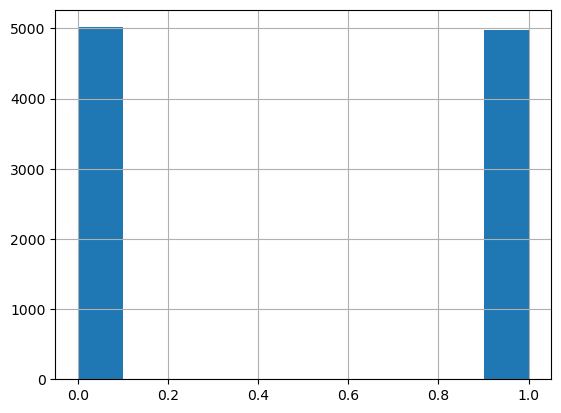

In [33]:
ys.hist()

In [34]:
from sklearn.model_selection import train_test_split

# we are spliting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 6), (2000, 6), (8000,), (2000,))

In [ ]:
# the combined pipeline for preprocessing and modeling for descision tree
dt_modeling_pipeline = Pipeline([
    ('data_processing', preprocessing_pipeline),
    ('ml', DecisionTreeClassifier())]
)
dt_modeling_pipeline

Pipeline(steps=[('data_processing',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   StandardScaler(),
                                                                   ['f1', 'f2',
                                                                    'f3', 'f4',
                                                                    'f5']),
                                                                  ('cat',
                                                                   OneHotEncoder(),
                                                                   ['f6'])]))])),
                ('ml', DecisionTreeClassifier())])

In [ ]:
# param grid for decision tree
dt_param_grid = [
    {
        'ml__max_depth' : [5, 10 ,15],
        'ml__min_samples_split' : [2, 4, 8],
        'ml__min_samples_leaf' : [1, 2, 4],
        'ml__criterion' : ['gini', 'entropy']
    }
]

scoring = "accuracy"

dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
dt_gcv_results = dt_gc.fit(X_train, y_train)

In [50]:
dt_gcv_results.best_params_

{'ml__criterion': 'entropy',
 'ml__max_depth': 10,
 'ml__min_samples_leaf': 2,
 'ml__min_samples_split': 4}

In [51]:
dt_gcv_results.score(X_train, y_train)

0.8805

In [52]:
dt_gcv_results.score(X_test, y_test)

0.7935

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, dt_gcv_results.predict(X_test), target_names=["A", "B"]))

              precision    recall  f1-score   support

           A       0.78      0.80      0.79       983
           B       0.80      0.78      0.79      1017

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



Well, the model has test accuracy of almost 80%. Given that the target is pretty much balanced, our recall and precision, and f1-score are very similar. Our training accuracy is 88% indicating slight overfitting. We can reduce model complexity to reduce overfitting as well.

In [ ]:
# the combined pipeline for preprocessing and modeling for random forest
rf_modeling_pipeline = Pipeline([
    ('data_processing', preprocessing_pipeline),
    ('ml', RandomForestClassifier())]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   StandardScaler(),
                                                                   ['f1', 'f2',
                                                                    'f3', 'f4',
                                                                    'f5']),
                                                                  ('cat',
                                                                   OneHotEncoder(),
                                                                   ['f6'])]))])),
                ('ml', RandomForestClassifier())])

In [ ]:
# param grid for random forest
rf_param_grid = [
    {
        'ml__max_depth' : [5, 6],
        'ml__min_samples_split' : [4, 8],
        'ml__min_samples_leaf' : [2, 4],
        "ml__n_jobs" : [-1],
        "ml__random_state" : [42],
    }
]

scoring = 'accuracy'

rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)
rf_gcv_results = rf_gc.fit(X_train, y_train)

In [62]:
rf_gcv_results.best_params_

{'ml__max_depth': 6,
 'ml__min_samples_leaf': 2,
 'ml__min_samples_split': 4,
 'ml__n_jobs': -1,
 'ml__random_state': 42}

In [63]:
rf_gcv_results.score(X_train, y_train)

0.821125

In [64]:
rf_gcv_results.score(X_test, y_test)

0.8095

In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_test, dt_gcv_results.predict(X_test), target_names=["A", "B"]))

              precision    recall  f1-score   support

           A       0.78      0.80      0.79       983
           B       0.80      0.78      0.79      1017

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



Well, with random forest, has slightly better test accuray of almost 81%. However, we can see that it has 82% training accuracy whereas decision tree had lmost 89% train accuracy. This shows that our RF model is not overfiting and is more robust.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# the combined pipeline for preprocessing and modeling for Kneighbors classifier
knn_modeling_pipeline = Pipeline([
    ('data_processing', preprocessing_pipeline),
    ('ml', KNeighborsClassifier())]
)

# param grid for KNeighbors classifier
knn_param_grid = [
    {
        'ml__n_neighbors' : [3, 5, 7],
        'ml__weights' : ['uniform', 'distance'],
    }
    
]

scoring = 'accuracy'
knn_gc = GridSearchCV(estimator=knn_modeling_pipeline, param_grid=knn_param_grid, cv=5, scoring=scoring)
knn_gcv_results = knn_gc.fit(X_train, y_train)

In [68]:
knn_gcv_results.best_params_

{'ml__n_neighbors': 7, 'ml__weights': 'distance'}

In [69]:
knn_gcv_results.score(X_train, y_train)

1.0

In [71]:
knn_gcv_results.score(X_test, y_test)

0.83

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, knn_gcv_results.predict(X_test), target_names=["A", "B"]))

              precision    recall  f1-score   support

           A       0.83      0.82      0.83       983
           B       0.83      0.84      0.83      1017

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



Well, KNN is overfitting actually as training accuracy is 100% and testing accuracy is 83%. If we experiment with more hyperparameters, we may get better performance and generalization. So far, I would still choose random forest model.

In [ ]:
from sklearn.naive_bayes import GaussianNB

# the combined pipeline for preprocessing and modeling for Naive Bayes
nb_modeling_pipeline = Pipeline([
    ('data_processing', preprocessing_pipeline),
    ('ml', GaussianNB())]
)

nb_param_grid = [
    {
        'ml__var_smoothing' : [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    }
]

scoring = 'accuracy'
nb_gc = GridSearchCV(estimator=nb_modeling_pipeline, param_grid=nb_param_grid, cv=5, scoring=scoring)   
nb_gcv_results = nb_gc.fit(X_train, y_train)

In [80]:
nb_gcv_results.best_params_

{'ml__var_smoothing': 1e-09}

In [81]:
nb_gcv_results.score(X_train, y_train)

0.703125

In [82]:
nb_gcv_results.score(X_test, y_test)

0.6895

In [83]:
from sklearn.metrics import classification_report
print(classification_report(y_test, nb_gcv_results.predict(X_test), target_names=["A", "B"]))

              precision    recall  f1-score   support

           A       0.69      0.67      0.68       983
           B       0.69      0.71      0.70      1017

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000



The Naive-Bayes model is kind of underperforming with training and test accuracy close to 70% and 69% respectively. Perhaps this models is not a good fit for a data this type. I also tried with Multinomial NB but it failed as the data has negative instances. So far, I would still chose RF model.

In [ ]:
from sklearn.svm import SVC

# the combined pipeline for preprocessing and modeling for SVM
svm_modeling_pipeline = Pipeline([
    ('data_processing', preprocessing_pipeline),
    ('ml', SVC())]
)

# param grid for SVM
svm_param_grid = [
    {
        'ml__C' : [0.1, 1, 10],
        'ml__kernel' : ['linear', 'rbf'],
        'ml__gamma' : ['scale', 'auto'],
    }
]   

scoring = 'accuracy'
svm_gc = GridSearchCV(estimator=svm_modeling_pipeline, param_grid=svm_param_grid, cv=5, scoring=scoring)
svm_gcv_results = svm_gc.fit(X_train, y_train)

In [85]:
svm_gcv_results.best_params_

{'ml__C': 10, 'ml__gamma': 'scale', 'ml__kernel': 'rbf'}

In [86]:
svm_gcv_results.score(X_train, y_train)

0.8525

In [87]:
svm_gcv_results.score(X_test, y_test)

0.839

In [88]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svm_gcv_results.predict(X_test), target_names=["A", "B"]))

              precision    recall  f1-score   support

           A       0.84      0.82      0.83       983
           B       0.83      0.85      0.84      1017

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



Woah! SVM outperformed RF model on test set along with all other models. This great. However, it took the most time for prediction as well. If you look at training set prediction, it took almost 2.6 seconds to process. It is very very slow algorithm, even though it may be accurate.

Depending upon the use case, I would still go with random forest model as it is still very fast on prediction and since it is built on top of weak learners, it gives good generalization and optimal tradeoff between bias and variance. So, I will choose Random Forest classifier.